In [1]:
import torch

In [2]:
device = 'cuda'
self = torch.device(device)

In [4]:
x = torch.rand(1, 3).to(device)

In [5]:
x

tensor([[0.6966, 0.0188, 0.0977]], device='cuda:0')

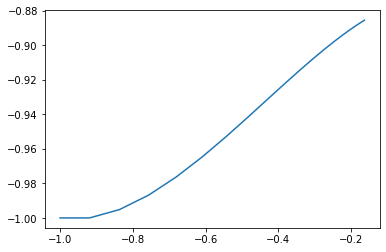

In [8]:
import crocoddyl
import numpy as np
import matplotlib.pyplot as plt

x0 = np.array([-1, -1,0 ]).reshape(-1, 1)
model = crocoddyl.ActionModelUnicycle()
model.costWeights = np.array([1., 1]).T
problem = crocoddyl.ShootingProblem(x0, [model]*20, model)
ddp = crocoddyl.SolverDDP(problem)
ddp.solve()

xs = np.array(ddp.xs)
plt.plot(xs[:,0], xs[:,1])
plt.show()

In [29]:
"""
A simple multioutput feedforward neural network to predict value function and trajectory given an initial starting state.
"""
import torch
import numpy as np
import torch.nn as nn
torch.set_default_dtype(torch.double)

class WarmstartNetwork(nn.Module):
    def __init__(self,
                state_dims:int  = 3,
                value_dims:int  = 1,
                horizon:int     = 30,
                fc1_dims:int    = 20,
                fc2_dims:int    = 20,
                fc3_dims:int    = 2,
                activation      = nn.Tanh(),
                device          = 'cpu'):
        super(WarmstartNetwork, self).__init__()


        """
        Create a simple feedforward neural network with pytorch.
        
        @params:
            1: state_dims  = input_features, i.e the number of features in the training dataset. This correponds to the dimension of the state space for the problem
            2: value_dims  = corresponds to ddp.cost. features. should be 1 for value
            3; xs_dims     = corresponds to ddp.xs, therefore should be len(horizon) + 1
            4: us_dims     = corresponds to ddp.us, therefore should be = len(horizon)
            2: fc1_dims    = number of units in the first fully connected layer. Default 20
            3: fc2_dims    = number of units in the second fully connected layer. Default 20
            4: fc3_dims    = number of units in the second fully connected layer. Default 20
            5: activation  = activation for the layers, default tanh.
            
        @returns:
            A 3 layered neural network with three outputs
            
            
        #########################################################################################################
        #   The architecture of the network is :                                                                #
        #                                                                                                       #
        #   x --> activation[layer1] ---> activation[layer2] ---> [layer3] == Value  , Trajectory, Control      #
        #                                                                                                       #
        #########################################################################################################
            
        """

        self.state_dims = state_dims
        self.value_dims = value_dims
        self.xs_dims    = horizon*3
        self.us_dims    = horizon*3
        self.fc1_dims   = fc1_dims
        self.fc2_dims   = fc2_dims
        self.fc3_dims   = fc3_dims
        self.activation = activation


        self.fc1 = nn.Linear(self.state_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.fc3_dims)
        
        # Value Output Layer
        self.fc4 = nn.Linear(self.fc3_dims, self.value_dims)
        # Trajectory Output Layer
        self.fc5 = nn.Linear(self.fc3_dims, self.xs_dims)
        # Control Output Layer
        self.fc6 = nn.Linear(self.fc3_dims, self.us_dims)

        # Weight Initialization protocol
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)
        nn.init.kaiming_normal_(self.fc4.weight)
        nn.init.kaiming_normal_(self.fc5.weight)
        nn.init.kaiming_normal_(self.fc6.weight)


        
        # Bias Initialization protocol
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.constant_(self.fc3.bias, 0)
        nn.init.constant_(self.fc4.bias, 0)
        nn.init.constant_(self.fc5.bias, 0)
        nn.init.constant_(self.fc6.bias, 0)



    def forward(self, state):
        """Calculate the value, trajectory and control from this state"""

        output = self.activation(self.fc1(state))
        output = self.activation(self.fc2(output))
        output = self.activation(self.fc3(output))
        
        value = self.fc4(output)
        trajectory = self.fc5(output)
        control = self.fc5(output)


        if self.xs_dims == 0: return value
        else: return value, trajectory, control

    def value_function(self, state):

        output = self.activation(self.fc1(state))
        output = self.activation(self.fc2(output))
        output = self.activation(self.fc3(output))
        value = self.fc4(output)

        return value

    def jacobian(self, state):
        """
        @Args:
            x = state
            
        @Returns
            The jacobian of the Value function with respect to state.
            Jacobian = dV/dx
        
        """
        return torch.autograd.functional.jacobian(self.value_function, state).squeeze()


    def hessian(self, state):
        """
        @Args:
            x = state
            
        @Returns
            The hessian of the Value function with respect to state.
            Hessian = d^2V/dx^2        
        """
        return torch.autograd.functional.hessian(self.value_function, state)

    def batch_jacobian(self, states):
        """
        Returns the jacobians of multiple inputs
        """
        j = [torch.autograd.functional.jacobian(self.value_function, state).squeeze() for state in states]
        return torch.stack(j).squeeze()
    
    def batch_hessian(self, states):
        """
        Returns the hessians of the multiple inputs 
        
        """
        h = [torch.autograd.functional.hessian(self.value_function, state).squeeze() for state in states]
        return torch.stack(h).squeeze()        

In [33]:
x = torch.rand(10, 3).to('cuda')
net = WarmstartNetwork(horizon=100)

#a, b, c = net(x)
#print(a[0], b[0].reshape(30, 3), c[0].reshape(30, 3))
net.to('cuda')
a= net(x)